In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=53b6fe9742b1244853bc82909d3a18102279ddd3c97adcd1b00f24ad45d131b2
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, when, to_date, count,first,lit,  monotonically_increasing_id, mean, lag, lead, round
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import requests
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
spark = SparkSession.builder.appName("Trading")\
        .config("spark.driver.memory", "10g")\
        .getOrCreate()

Crawl dữ liệu cổ phiếu

In [ ]:
# Thu thập các mã cổ phiếu
trade_centers = ['HOSE', 'UPCOM', 'VN30', 'HATSC']    # Các sàn chứng khoán đang hoạt động tại thị trường Việt Nam
tickers = []
def crawl_ticker(trade_center):
  response = requests.get('https://s.cafef.vn/Ajax/PageNew/DataGDNN/GDNuocNgoai.ashx?TradeCenter={}&Date='.format(trade_center))
  if response.status_code == 200:
    records = response.json().get('Data', {}).get('ListDataNN', [])
    for record in records:
      tickers.append({'ticker': record.get('Symbol')})

for trade_center in trade_centers:
  crawl_ticker(trade_center)
tickers = spark.createDataFrame(tickers)
tickers.show()

+--------+
|  ticker|
+--------+
|     BCG|
|     MSN|
|     VNM|
|FUEVFVND|
|     HSG|
|     PC1|
|     HHV|
|     HNG|
|     DPM|
|     SHB|
|     EIB|
|     DHC|
|     IDI|
|     HDB|
|     CTG|
|     GMD|
|     FIR|
|     KSB|
|     SAB|
|     OCB|
+--------+
only showing top 20 rows



In [ ]:
# Thông tin cổ phiếu
schema = StructType([
    StructField("ticker", StringType(), True),
    StructField("day", StringType(), True),
    StructField("open", FloatType(), True),
    StructField("close", FloatType(), True),
    StructField("volume", IntegerType(), True),
    StructField("high", FloatType(), True),
    StructField("low", FloatType(), True)
])


@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def crawl_data_udf(data):
    stock_data = []
    for _, row in data.iterrows():
        symbol = row['ticker']
        response = requests.get('https://s.cafef.vn/Ajax/PageNew/DataHistory/PriceHistory.ashx?Symbol={}&StartDate=&EndDate=&PageIndex=1&PageSize=10000'.format(symbol))
        if response.status_code == 200:
            records = response.json().get('Data', {}).get('Data', [])
            for record in records:
                stock_data.append({
                    'ticker': symbol,
                    'day': record.get('Ngay'),
                    'open': record.get('GiaMoCua'),
                    'close': record.get('GiaDongCua'),
                    'volume': record.get('KhoiLuongKhopLenh'),
                    'high': record.get('GiaCaoNhat'),
                    'low': record.get('GiaThapNhat')
                })
    return pd.DataFrame(stock_data)

tickers_df = spark.read.csv("ticker.csv", header=True, inferSchema=True)

data = tickers_df.groupby('ticker').apply(crawl_data_udf)

data = data.coalesce(1)  # Gộp tất cả partitions thành 1

# Ghi dữ liệu vào file cafef_spark.csv
data.write.csv('cafef_spark.csv', header=True, mode="overwrite")

#data.repartition(1).write.csv('cafef_spark.csv', header=True, mode="overwrite")

# data.show()

+------+----------+----+-----+------+----+----+
|ticker|       day|open|close|volume|high| low|
+------+----------+----+-----+------+----+----+
|   A32|05/06/2024|36.0| 36.0|    17| 0.0| 0.0|
|   A32|04/06/2024|36.0| 36.0|     0|36.0|36.0|
|   A32|03/06/2024|36.0| 36.0|   106|36.0|36.0|
|   A32|31/05/2024|37.3| 37.3|     0|37.3|37.3|
|   A32|30/05/2024|37.3| 37.5|    10|37.3|37.3|
|   A32|29/05/2024|37.3| 37.5|    17|37.3|37.3|
|   A32|28/05/2024|37.3| 37.5|    11|37.3|37.3|
|   A32|27/05/2024|37.0| 37.5|   202|37.5|37.0|
|   A32|24/05/2024|35.0| 35.0|   107|35.0|35.0|
|   A32|23/05/2024|33.5| 33.5|    10|33.5|33.5|
|   A32|22/05/2024|33.5| 33.5|   154|33.5|33.5|
|   A32|21/05/2024|32.2| 32.2|     1|32.2|32.2|
|   A32|20/05/2024|32.2| 32.2|     1|32.2|32.2|
|   A32|17/05/2024|32.2| 32.2|     0|32.2|32.2|
|   A32|16/05/2024|32.2| 32.2|     0|32.2|32.2|
|   A32|15/05/2024|32.2| 32.2|     2|32.2|32.2|
|   A32|14/05/2024|32.2| 32.2|     0|32.2|32.2|
|   A32|13/05/2024|32.2| 32.2|     2|32.

Tiền xử lý dữ liệu

In [ ]:
data = data.withColumn('day', to_date(data['day'], 'dd/MM/yyyy')).sort('day')

# Chuyển dữ liệu bảng với các cột là tên các ticker, giá trị là giá đóng cửa
table = data.groupBy('day').pivot('ticker').agg(first("close"))

In [ ]:
# Lấy các cổ phiếu từ ngày 01/01/2011
table = table[table['day'] >= '2011-01-01']
columns = table.columns

# Tính số lượng giá trị không null cho mỗi cột
non_null_counts = table.select(
    [count(when(col(c).isNotNull(), 1)).alias(c) for c in columns]
).collect()[0]
non_null_counts_dict = {col: non_null_counts[col] for col in columns}

# Lọc ra các cột có số lượng giá trị không null lớn hơn 3250 phiên giao dịch
columns_to_keep = [col for col, count in non_null_counts_dict.items() if count > 3250]

# Tạo DataFrame mới chỉ chứa các cột thỏa mãn điều kiện
table = table.select(columns_to_keep)
#table.show()

In [ ]:
# Thay các giá trị null bằng trung bình của giá trị xung quanh
def fill_nan_with_neighbors_avg(col_name):
    window_spec = Window.orderBy("id")
    lag_col = lag(col_name).over(window_spec)
    lead_col = lead(col_name).over(window_spec)
    avg_col = (lag_col + lead_col) / 2
    return when(col(col_name).isNull(), round(avg_col, 2)).otherwise(col(col_name))

# Thêm cột id để ghép dữ liệu
table = table.withColumn("id", monotonically_increasing_id()).cache()

# Thực hiện xử lý cho từng cột
for column in table.columns:
    if column != 'day' and column != 'id':
        table = table.withColumn(column, fill_nan_with_neighbors_avg(column))
# Loại bỏ cột "id"
table = table.drop("id")

# Hiển thị kết quả
table.show()

+----------+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+---+----+-----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+---+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+----+----+---+----+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+---+----+---+----+----+---+---+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+----+----+----+----+----+----+----+----+----+----+----+----

In [ ]:
table = table.drop('IME')

Tối ưu danh mục

In [ ]:
# Tính % thay đổi giữa các ngày
window_spec = Window.orderBy("day")
columns = [col for col in table.columns if col != 'day']
returns_daily = table
column_trans = [((F.col(col) - F.lag(col).over(window_spec)) / F.lag(col).over(window_spec)).alias(col) for col in returns_daily.columns if col != 'day']

# Sử dụng select() để áp dụng các biến đổi cho tất cả các cột cùng một lúc
returns_daily = returns_daily.select(column_trans)
# returns_daily.show()

In [ ]:
# spark = SparkSession.builder \
#     .appName("Trading") \
#     .config("spark.driver.memory", "6g")\
#     .getOrCreate()

In [ ]:
returns_daily = returns_daily.toPandas()

In [ ]:
# Chuyển về pd dataframe để tính giá trị trung bình và ma trận hiệp phương sai
expected_returns_annual = returns_daily.mean()*250
cov_matrix_annual = returns_daily.cov()*250
print("loi suat ky vong: \n",expected_returns_annual)
print('\n ================================================================\n')
print("ma tran hiep phuong sai: \n",cov_matrix_annual)

loi suat ky vong: 
 AAA    0.010479
AAM    0.006383
ABI    0.292621
ABT    0.053666
ACB    0.045463
         ...   
VTL   -0.064821
VTO    0.084308
VTS    0.161618
WSB    0.191621
YBC    0.328486
Length: 326, dtype: float64


ma tran hiep phuong sai: 
           AAA       AAM       ABI       ABT       ACB       ACC       ACL  \
AAA  0.172325  0.011208  0.027572  0.015071  0.040270  0.017981  0.035694   
AAM  0.011208  0.176378  0.008338  0.006485  0.006943  0.001245  0.015454   
ABI  0.027572  0.008338  0.402235  0.004295  0.017600  0.021880  0.020841   
ABT  0.015071  0.006485  0.004295  0.137751  0.007644  0.004630  0.010244   
ACB  0.040270  0.006943  0.017600  0.007644  0.094327  0.011077  0.015904   
..        ...       ...       ...       ...       ...       ...       ...   
VTL  0.004008  0.000517  0.002473  0.002317  0.007194  0.002434 -0.005841   
VTO  0.048959  0.013101  0.021784  0.009935  0.026353  0.018781  0.026411   
VTS  0.012013  0.005308 -0.000474  0.000068  0.001533 

In [ ]:
import numpy as np
from scipy.optimize import minimize
# Hàm tối ưu hóa Sharpe Ratio
def optimize_portfolio(returns, covariance):
    num_assets = len(returns)
    args = (returns, covariance)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0, 1.0) for asset in range(num_assets))

    def negative_sharpe_ratio(weights, returns, covariance):
        portfolio_return = np.dot(weights, returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
        sharpe_ratio = portfolio_return / portfolio_volatility
        return -sharpe_ratio

    initial_guess = num_assets * [1./num_assets,]
    result = minimize(negative_sharpe_ratio, initial_guess, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [ ]:
# Tối ưu hóa danh mục đầu tư
optimal_result = optimize_portfolio(expected_returns_annual, cov_matrix_annual)

# Lấy 5 mã cổ phiếu có tỷ trọng cao nhất
top_indices = np.argsort(optimal_result.x)[-5:]
top_weights = optimal_result.x[top_indices]
top_tickers = [columns[i] for i in top_indices]
sum_weight = np.sum(top_weights)
for i in range(5):
  top_weights[i] = top_weights[i]/sum_weight

In [ ]:
for ticker, weight in zip(top_tickers, top_weights):
    print('Mã cổ phiếu: {}, Tỷ trọng: {}%'.format(ticker,100*weight))

Mã cổ phiếu: CHP, Tỷ trọng: 18.280958895092624%
Mã cổ phiếu: ND2, Tỷ trọng: 18.93951678909305%
Mã cổ phiếu: TDW, Tỷ trọng: 19.895840872897132%
Mã cổ phiếu: SHP, Tỷ trọng: 20.6488880167563%
Mã cổ phiếu: TMP, Tỷ trọng: 22.234795426160897%


In [ ]:
# Danh sách và tỷ trọng của 5 mã
for ticker, weight in zip(top_tickers, top_weights):
    print('Mã cổ phiếu: {}, Tỷ trọng: {}%'.format(ticker,100*weight))

Mã cổ phiếu: ND2, Tỷ trọng: 18.826998242827905%
Mã cổ phiếu: TDW, Tỷ trọng: 19.360753373111695%
Mã cổ phiếu: IME, Tỷ trọng: 20.24577254462232%
Mã cổ phiếu: SHP, Tỷ trọng: 20.25188579720782%
Mã cổ phiếu: TMP, Tỷ trọng: 21.314590042230275%


Tín hiệu mua và bán

In [ ]:
# Tạo 1 dictionary để lưu thông tin các mã cổ phiếu cần phân tích
dfs = {}
for ticker in top_tickers:
      dfs[ticker] = table.select('day', ticker)
      #dfs[ticker] = dfs[ticker].withColumnRenamed(ticker, "price")
      # dfs[ticker] = dfs[ticker].dropna()

In [ ]:
for ticker in top_tickers:
  dfs[ticker].show()

+----------+-----+
|       day|price|
+----------+-----+
|2011-01-17|  9.2|
|2011-01-18|  9.2|
|2011-01-19|  8.9|
|2011-01-20|  8.9|
|2011-01-21|  8.6|
|2011-01-24|  8.5|
|2011-01-25|  8.9|
|2011-01-26|  8.9|
|2011-01-27|  8.5|
|2011-01-28|  8.8|
|2011-02-08|  9.2|
|2011-02-09|  9.2|
|2011-02-10|  9.2|
|2011-02-11|  8.9|
|2011-02-14|  8.9|
|2011-02-15|  8.9|
|2011-02-16|  8.9|
|2011-02-17|  8.9|
|2011-02-18|  8.5|
|2011-02-21|  8.8|
+----------+-----+
only showing top 20 rows

+----------+-----+
|       day|price|
+----------+-----+
|2011-01-17| 46.0|
|2011-01-18| 46.0|
|2011-01-19| 46.0|
|2011-01-20| 46.0|
|2011-01-21| 46.0|
|2011-01-24| 46.0|
|2011-01-25| 46.0|
|2011-01-26| 46.0|
|2011-01-27| 46.0|
|2011-01-28| 46.0|
|2011-02-08| 46.0|
|2011-02-09| 46.0|
|2011-02-10| 46.0|
|2011-02-11| 46.0|
|2011-02-14| 46.0|
|2011-02-15| 46.0|
|2011-02-16| 46.0|
|2011-02-17| 46.0|
|2011-02-18| 46.0|
|2011-02-21| 46.0|
+----------+-----+
only showing top 20 rows

+----------+-----+
|       day|price

In [ ]:
# Tính SMA 20, SMA 50
# Nếu SMA 20 > SMA 50 (có tín hiệu tăng giá) => đánh dấu signal = 1
# Kiểm tra sự thay đổi của các giá trị signal bên cạnh, nếu position = 1 => tín hiệu mua; position = -1 => tín hiệu bán
for ticker in top_tickers:
    window_20 = Window.rowsBetween(-19, 0)
    window_50 = Window.rowsBetween(-49, 0)

    dfs[ticker] = dfs[ticker].withColumn('20_SMA', F.round(F.avg(ticker).over(window_20), 2))
    dfs[ticker] = dfs[ticker].withColumn('50_SMA', F.round(F.avg(ticker).over(window_50), 2))

    dfs[ticker] = dfs[ticker].withColumn('signal', F.when(F.col('20_SMA') > F.col('50_SMA'), 1.0).otherwise(0.0))

    dfs[ticker] = dfs[ticker].withColumn('position', F.col('signal') - F.lag('signal').over(Window.orderBy('day')))

# for ticker in top_tickers:
#     print(ticker)
#     dfs[ticker].show()
#     print('======================================================')

Thử nghiệm và đánh giá thuật toán

In [ ]:
# Kiểm tra ngày có giao dịch không
days = table.select('day').toPandas()
days.set_index('day', inplace=True)
# days.index = pd.to_datetime(days.index, format='%Y/%m/%d')
def check(date):
  while 1:
    if date in days.index:
      print(date)
      return date
    else:
      date += timedelta(days = 1)
      print(date)

In [ ]:
for ticker in top_tickers:
  dfs[ticker] = dfs[ticker].toPandas()
  dfs[ticker].set_index('day', inplace=True)

In [ ]:
# Dữ liệu đầu vào
initial_capital = 100000
start_day = datetime.strptime('05/04/2023', '%m/%d/%Y').date()
# end_day = datetime.strptime('05/01/2024', '%m/%d/%Y')
# Kiểm tra ngày bắt đầu và kết thúc có thỏa mãn điều kiện không
end_day = days.iloc[-1].name
capital = [0] * 5
volumn = [0] * 5


In [ ]:
# Lọc cổ phiếu theo thời gian vừa đặt
for ticker in top_tickers:
    dfs[ticker] = dfs[ticker].loc[start_day:end_day]

In [ ]:
ticker = 'IME'
dfs[ticker]['IME']

day
2023-05-04    141.0
2023-05-05    141.0
2023-05-08    141.0
2023-05-09    141.0
2023-05-10    141.0
              ...  
2024-05-20    141.0
2024-05-21    141.0
2024-05-22    141.0
2024-05-23    141.0
2024-05-24    141.0
Name: IME, Length: 265, dtype: float64

In [ ]:
# Chia số vốn theo tỷ trọng đã tính
for i in range(5):
  capital[i] = top_weights[i] * initial_capital

In [ ]:
test_day = start_day
volumn = [0] * 5
capital = [0] * 5

initial_capital = 1000000 #(tương ứng 1 tỏi vnđ)


# Chia số vốn theo tỷ trọng như trên
for i in range(5):
  capital[i] = top_weights[i] * initial_capital

# Tạo dataframe để lưu tổng lợi nhuận và vốn
total_capital = pd.DataFrame()
total_capital.index = dfs['TDW'].index
total_capital['value'] = 0


# Mỗi lần mua sẽ mua với 50% vốn, bán với 70% volumn đang giữ
while test_day <= end_day:
  test_day = check(test_day)
  print('Ngày: ', test_day)

  #test_date = test_date.strftime('%m/%d/%Y')
  a= 0
  for i, ticker in enumerate(top_tickers):
    price = dfs[ticker][ticker].loc[test_day]
    if volumn[i] == 0:     # Mua
      if dfs[ticker]['signal'].loc[start_day] == 1:
        volumn[i] += int((capital[i] * 0.3)/ price)
        capital[i] -= int((capital[i] * 0.3)/ price) * price

    if dfs[ticker]['position'].loc[test_day] == 1 and capital[i] >= price: #Mua
        volumn[i] += int((capital[i] * 1)/ price)
        capital[i] -= int((capital[i] * 1)/ price) * price

    elif dfs[ticker]['position'].loc[test_day] == -1:     # Bán
        capital[i] += int(volumn[i] * 0.3) * price
        volumn[i] -= int(volumn[i] * 0.3)
    print('ticker: {}, volumn: {}, giá: {}, vốn: {} '. format(ticker,volumn[i], price ,capital[i]))

    a += (capital[i] + volumn[i] * price)
  #test_date = pd.to_datetime(test_date, format = '%m/%d/%Y')
  total_capital['value'].loc[test_day] = a
  test_day += timedelta(days= 1)
  if test_day > end_day:
    break

2023-05-04
Ngày:  2023-05-04
ticker: CHP, volumn: 2229, giá: 24.6, vốn: 127976.18895092627 
ticker: ND2, volumn: 0, giá: 30.2, vốn: 189395.16789093052 
ticker: TDW, volumn: 0, giá: 43.0, vốn: 198958.4087289713 
ticker: SHP, volumn: 2212, giá: 28.0, vốn: 144552.88016756298 
ticker: TMP, volumn: 0, giá: 55.5, vốn: 222347.95426160897 
2023-05-05
Ngày:  2023-05-05
ticker: CHP, volumn: 2229, giá: 24.7, vốn: 127976.18895092627 
ticker: ND2, volumn: 0, giá: 32.0, vốn: 189395.16789093052 
ticker: TDW, volumn: 0, giá: 43.0, vốn: 198958.4087289713 
ticker: SHP, volumn: 2212, giá: 27.5, vốn: 144552.88016756298 
ticker: TMP, volumn: 0, giá: 55.2, vốn: 222347.95426160897 
2023-05-07
2023-05-08
2023-05-08
Ngày:  2023-05-08
ticker: CHP, volumn: 2229, giá: 24.4, vốn: 127976.18895092627 
ticker: ND2, volumn: 0, giá: 28.5, vốn: 189395.16789093052 
ticker: TDW, volumn: 0, giá: 41.0, vốn: 198958.4087289713 
ticker: SHP, volumn: 2212, giá: 28.15, vốn: 144552.88016756298 
ticker: TMP, volumn: 0, giá: 53.5, 

In [ ]:
end_day

datetime.date(2024, 5, 24)

In [ ]:
# Tính lãi lỗ
print('Lợi nhuận khi thực hiện theo thuật toán: {}%'.format(100*round((sum(capital) - initial_capital)/initial_capital, 4)))

PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got float64.

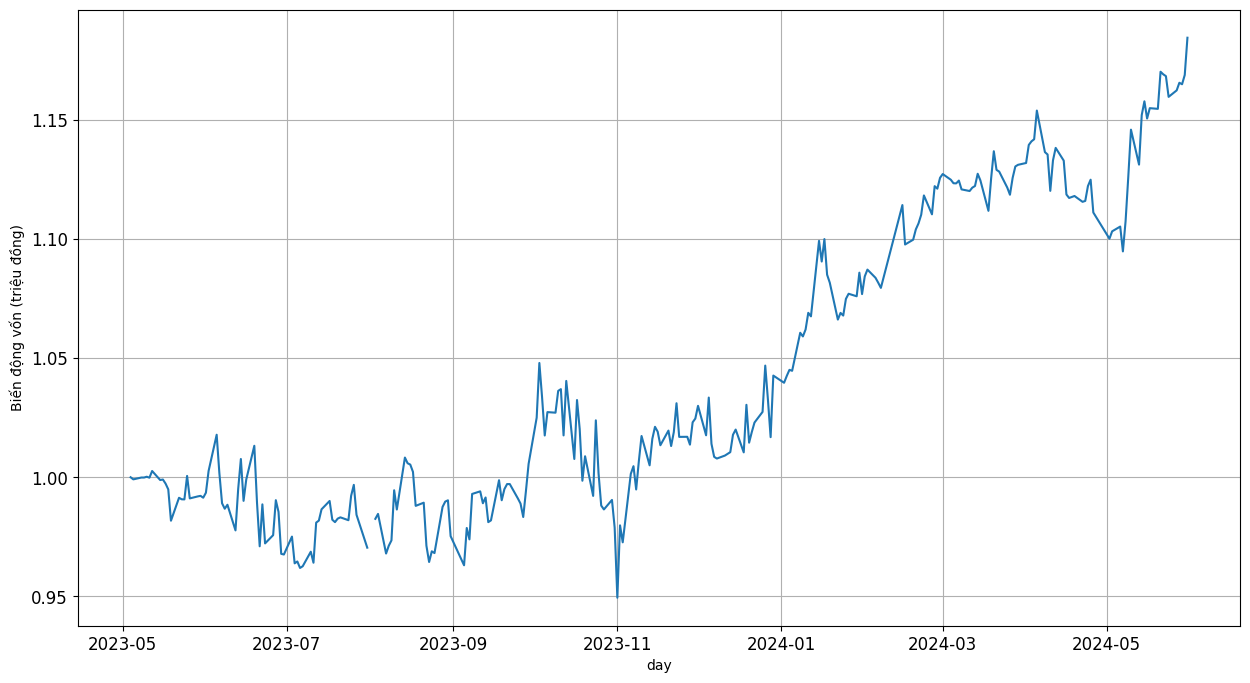

In [ ]:
import matplotlib.pyplot as plt
(total_capital['value']/1000000).plot(figsize = (15, 8), fontsize = 12)
plt.grid()
plt.ylabel('Biến động vốn (tỷ đồng)')
plt.show()

In [ ]:
total_capital.iloc[-1]

value    1184530.85
Name: 2024-05-31, dtype: float64